# AGF-345
Polar Magnetospheric Substorms

## Auroral Acceleration - Exercise 1

### Authors

 - Martin Claude Joseph Baudry
 - Jeanne Longlune
 - Michał Jan Odorczuk
 - Inés Eleonor Santandreu Ros
 - Ana Filipa Sousa Barros

### Description

This file processes the magnetic field line data from [Tsyganienko](https://ccmc.gsfc.nasa.gov/requests/instant/tsyganenko_results.php) and displays the field lines for three given locations (LYR: Longyearbyen, BJR: Bjørnøya, TRM:Tromsø) for IMF data from 07/11/2023 for two hours (00 and 17).

### Necessary imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re

### Utility funcitons

In [2]:
def load_data_from_file(file_name):
    """
    Loads data from the provided file into a Pandas DataFrame.
    Skips the first two rows (header rows).
    """
    df = pd.read_csv(file_name, delim_whitespace=True, comment='#')
    df = df[1:]  # Skip the first row containing the units
    cols = df.columns
    for col in cols:
        df[col] = df[col].astype(float)
    return df

def normalize_magnetic_field(df):
    """
    Normalizes the magnetic field components (BX, BY, BZ).
    Adds new columns for normalized magnetic field components.
    """
    magnitude = np.sqrt(df['BXGSM']**2 + df['BYGSM']**2 + df['BZGSM']**2)
    df['BX_norm'] = df['BXGSM'] / magnitude
    df['BY_norm'] = df['BYGSM'] / magnitude
    df['BZ_norm'] = df['BZGSM'] / magnitude
    return df

def extract_metadata(file_name):
    """
    Extracts metadata from the provided file name. File name format: B_<day>_<year>_<model>_<location>_<hour>.txt
    """
    match = re.search(r'B_(\d+)_(\d+)_([a-zA-Z0-9]+)_([A-Z]+)_(\d+)\.txt', file_name)
    d = {"day": "Unknown", "year": "Unknown", "model": "Unknown", "location": "Unknown", "hour": "Unknown"}
    if match:
        d["day"] = match.group(1)  # Day of the year
        d["year"] = match.group(2)  # Year
        d["model"] = match.group(3)  # Model code
        d["location"] = match.group(4)  # Location code
        d["hour"] = match.group(5)  # Hour of the day
    return d

def extract_city_code(file_name):
    return extract_metadata(file_name)["location"]

def get_file_metadata(file_path):
    header_dict = {}

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Check if the line starts with a hash and is not empty
            if line.startswith('#'):
                # Remove the leading '# ' and split on the first occurrence of ':'
                key, value = line.lstrip('# ').strip().split(': ', 1)
                # Store the key-value pair in the dictionary
                header_dict[key] = value

    return header_dict


### Plotting

In [3]:
def process_files_in_directory(directory):
    files = [file for file in os.listdir(directory) if file[-4:] == ".txt"]
    all_data = []

    for file_name in files:
        print(f"Processing file: {file_name}")
        file_path = os.path.join(directory, file_name)
        df = load_data_from_file(file_path)
        df_normalized = normalize_magnetic_field(df)
        city_code = extract_city_code(file_name)
        df_normalized['City'] = city_code  # Add city code to the DataFrame
        all_data.append(df_normalized)
    full_df = pd.concat(all_data, ignore_index=True)
    return full_df

def create_3d_quiver_plot(df, scale=0.1, zoom=True, save_as=None, arrows=True,
        metadata={"Hour": "Unknown", "Day": "Unknown", "Year": "Unknown", "ts_version": "Unknown"}):
    """
    Creates a 3D quiver plot using the combined filtered and normalized data.
    Optionally saves the plot with or without arrows, and with zoom option.
    """
    if zoom:
        df = df[df['R'] < 1.5]
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')


    """
    Display Earth as a blue sphere
    """
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="b")

    sc = ax.scatter(
        df['XGSM'], df['YGSM'], df['ZGSM'],
        norm=colors.LogNorm(vmin=10, vmax=1e5),
        c=df['B'], cmap='viridis', s=30, label='Positions (Filtered)'
    )

    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label('B [nT]', rotation=270, labelpad=15)

    ax.set_xlabel('XGSM [Re]')
    ax.set_ylabel('YGSM [Re]')
    ax.set_zlabel('ZGSM [Re]')
    ax.set_title(f'3D Plot of Magnetic Field - {metadata["Hour"]}')

    # if zoom:
    #     ax.set_xlim([-1.5, 1.5])
    #     ax.set_ylim([-1.5, 1.5])
    #     ax.set_zlim([-1.5, 1.5])
    # else:
    #     ax.set_xlim([df['XGSM'].min(), df['XGSM'].max()])
    #     ax.set_ylim([df['YGSM'].min(), df['YGSM'].max()])
    #     ax.set_zlim([df['ZGSM'].min(), df['ZGSM'].max()])

    labeled_cities = set()

    for city in df['City'].unique():
        if city in labeled_cities:
            continue

        city_data = df[df['City'] == city]
        middle_index = len(city_data) // 2
        middle_row = city_data.iloc[middle_index]

        offset_x = 0.2
        offset_y = 0.2
        offset_z = 0.2

        ax.text(
            middle_row['XGSM'] + offset_x,
            middle_row['YGSM'] + offset_y,
            middle_row['ZGSM'] + offset_z,
            middle_row['City'], fontsize=8, color='blue'
        )

        labeled_cities.add(city)

    if arrows:
        ax.quiver(
            df['XGSM'], df['YGSM'], df['ZGSM'],
            df['BX_norm'] * scale, df['BY_norm'] * scale, df['BZ_norm'] * scale,
            color='r', length=0.5, normalize=False, linewidth=0.5, label='Normalized Field Vectors'
        )

    ax.legend()
    ax.axes.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    if save_as:
        fig.savefig(save_as, format='jpg')
        print(f"Plot saved as {save_as}")
    display(metadata)

def process_all_hours(directory):
    """
    Processes each subdirectory (hour folder) in the given directory and generates plots.
    """
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for subdirectory in subdirectories:
        hour_label = subdirectory[-2:]  # Get the last two characters (YY) from folder name, e.g., '00' or '17'
        print(f"Processing data for Hour {hour_label}...")

        # Get the path for the subdirectory
        subdirectory_path = os.path.join(directory, subdirectory)

        # Process files in the subdirectory
        combined_df = process_files_in_directory(subdirectory_path)

        # Get metadata from the first file in the subdirectory
        metadata = get_file_metadata(subdirectory_path + "/" + os.listdir(subdirectory_path)[0])

        # Create and save the plots
        create_3d_quiver_plot(combined_df, scale=0.1, zoom=True, save_as=f"3d_plot_with_arrows_hour_{hour_label}.jpg", arrows=True, metadata=metadata)
        create_3d_quiver_plot(combined_df, scale=0.1, zoom=False, save_as=f"3d_plot_without_arrows_hour_{hour_label}.jpg", arrows=False, metadata=metadata)

Processing data for Hour 17...
Processing file: B_311_2015_T01_TRM_17.txt
Processing file: B_311_2015_T01_LYR_17.txt
Processing file: B_311_2015_T01_BJR_17.txt


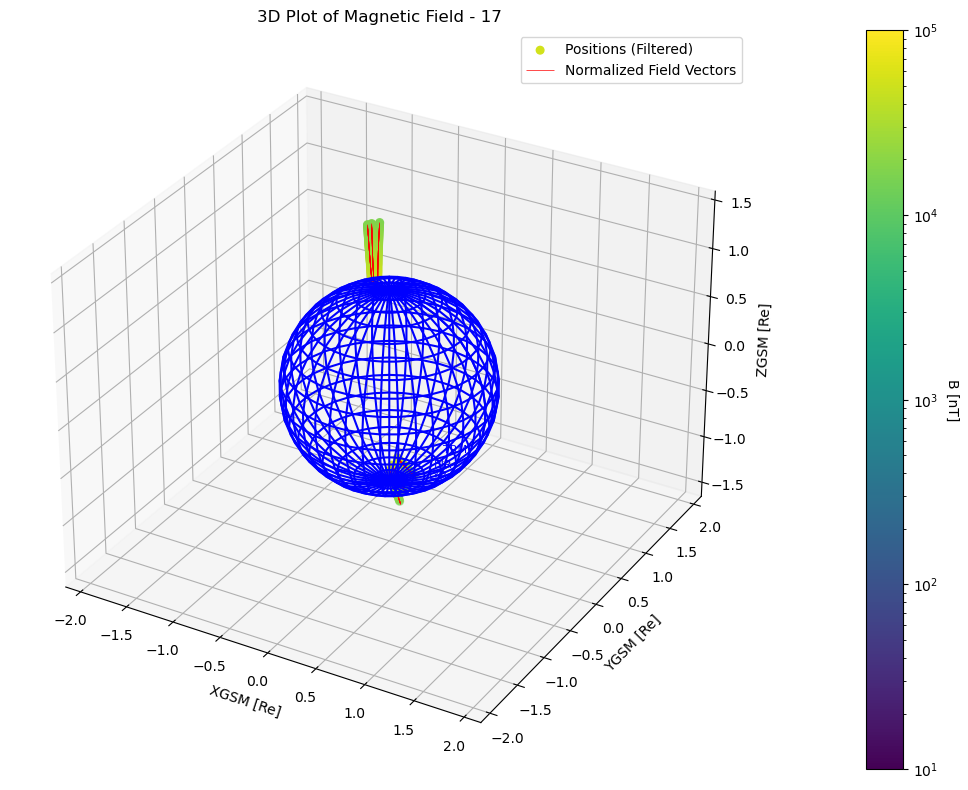

Plot saved as 3d_plot_with_arrows_hour_17.jpg


{'ts_version': '01',
 'Year': '2015',
 'Day': '311',
 'Hour': '17',
 'Minute': '00',
 'Second': '00',
 'SW dynamic pressure': '2.6',
 'SW velocity': '700.0',
 'IMF By': '-1.3',
 'IMF Bz': '3.9',
 'Dst': '-34.0',
 'DIR': '1',
 'Geographic Geocentric Latitude': '69.65',
 'Longitude': '18.955',
 'Xgsm': '1.',
 'Ygsm': '1.',
 'Zgsm': '1.'}

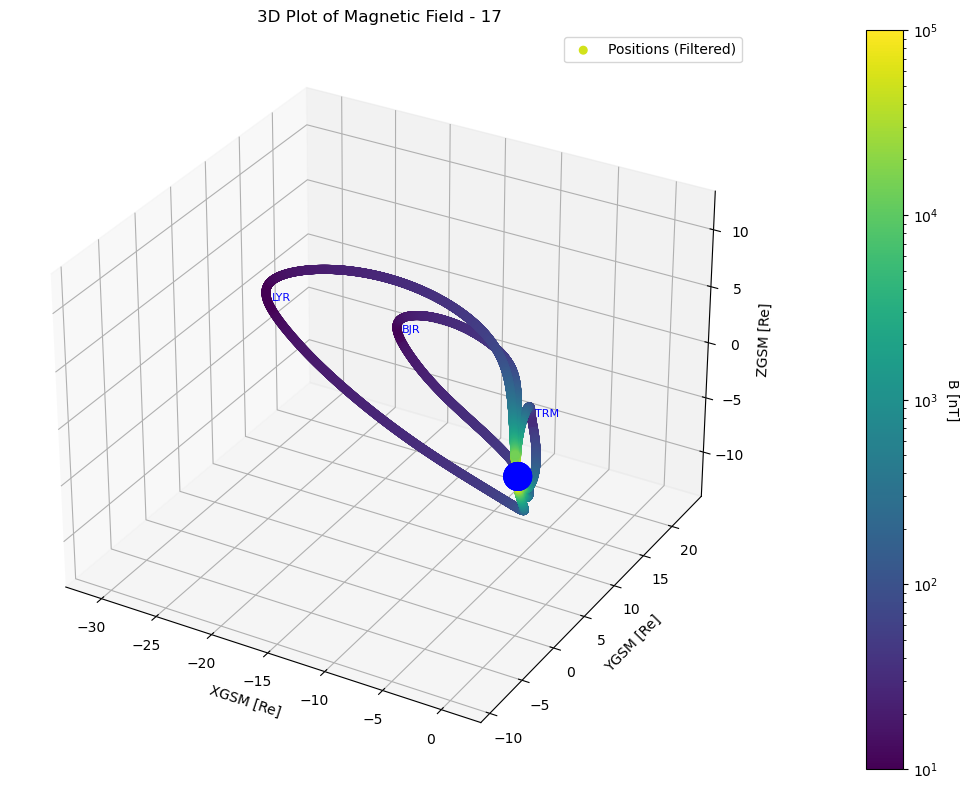

Plot saved as 3d_plot_without_arrows_hour_17.jpg


{'ts_version': '01',
 'Year': '2015',
 'Day': '311',
 'Hour': '17',
 'Minute': '00',
 'Second': '00',
 'SW dynamic pressure': '2.6',
 'SW velocity': '700.0',
 'IMF By': '-1.3',
 'IMF Bz': '3.9',
 'Dst': '-34.0',
 'DIR': '1',
 'Geographic Geocentric Latitude': '69.65',
 'Longitude': '18.955',
 'Xgsm': '1.',
 'Ygsm': '1.',
 'Zgsm': '1.'}

Processing data for Hour 00...
Processing file: B_311_2015_T01_BJR_00.txt
Processing file: B_311_2015_T01_TRM_00.txt
Processing file: B_311_2015_T01_LYR_00.txt


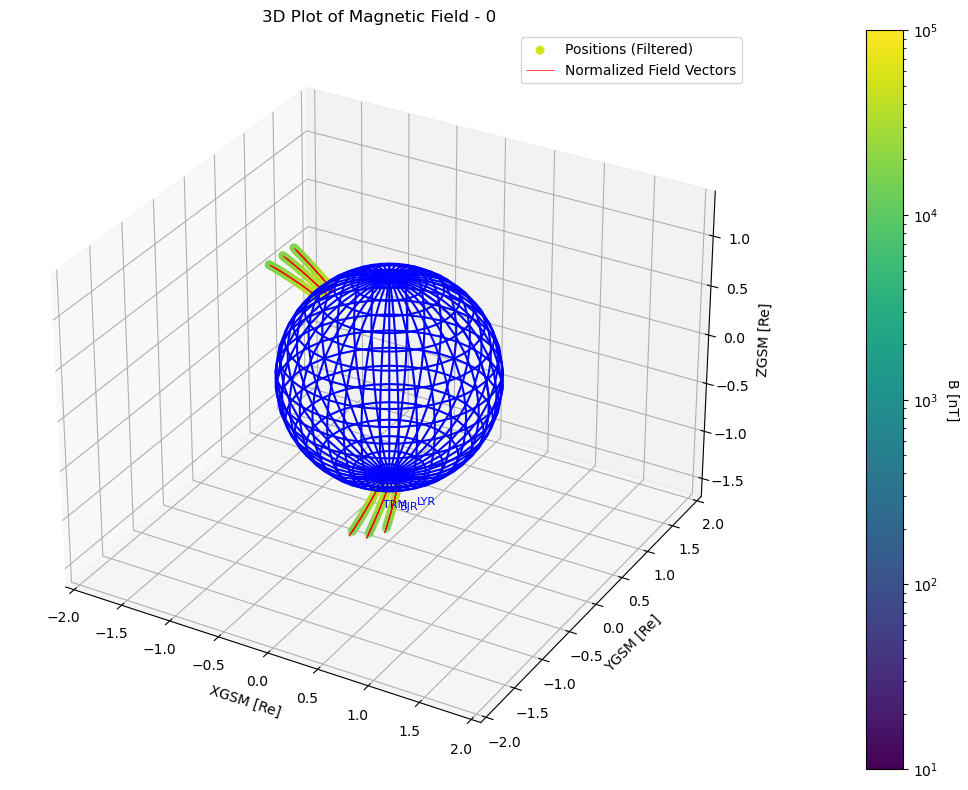

Plot saved as 3d_plot_with_arrows_hour_00.jpg


{'ts_version': '01',
 'Year': '2015',
 'Day': '311',
 'Hour': '0',
 'Minute': '00',
 'Second': '00',
 'SW dynamic pressure': '2.3',
 'SW velocity': '721.0',
 'IMF By': '-2.6',
 'IMF Bz': '-3.7',
 'Dst': '-62.0',
 'DIR': '1',
 'Geographic Geocentric Latitude': '74.443',
 'Longitude': '19.016',
 'Xgsm': '1.',
 'Ygsm': '1.',
 'Zgsm': '1.'}

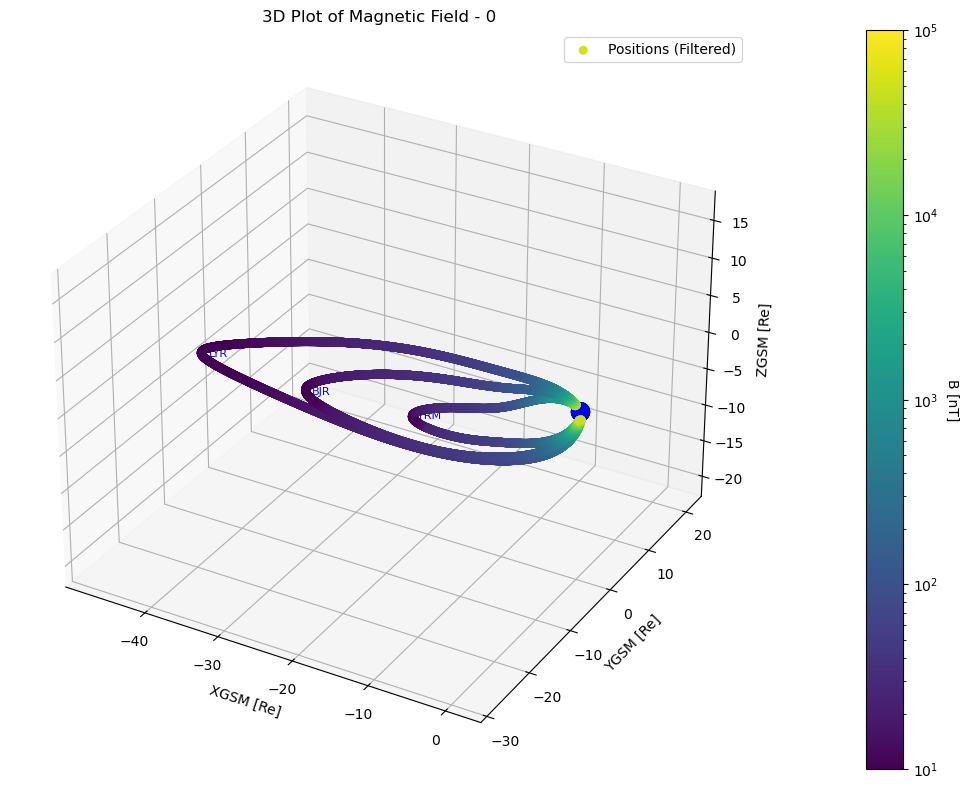

Plot saved as 3d_plot_without_arrows_hour_00.jpg


{'ts_version': '01',
 'Year': '2015',
 'Day': '311',
 'Hour': '0',
 'Minute': '00',
 'Second': '00',
 'SW dynamic pressure': '2.3',
 'SW velocity': '721.0',
 'IMF By': '-2.6',
 'IMF Bz': '-3.7',
 'Dst': '-62.0',
 'DIR': '1',
 'Geographic Geocentric Latitude': '74.443',
 'Longitude': '19.016',
 'Xgsm': '1.',
 'Ygsm': '1.',
 'Zgsm': '1.'}

In [4]:
# Run the process for all subdirectories inside './Data'
directory = "../data/Tsy"  # Parent directory containing '311_00' and '311_17'
process_all_hours(directory)